In [161]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import * 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from urllib.request import urlretrieve
from owslib.wfs import WebFeatureService
from dotenv import load_dotenv
from pyspark.sql import functions as F

# Create a spark session
spark = (
    SparkSession.builder.appName("analysis")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "2g")
    .config("spark.executor.memory", "6g")
    .getOrCreate()
)

# Transactions per merchant per month

In [162]:
finaldf = spark.read.parquet("../data/curated/finaldf.parquet/")
finaldf.limit(5)

order_datetime,merchant_abn,user_id,postcode,consumer_id,dollar_value,order_id,state,gender,company_name,tags,take_rate,revenue_band,total_pop,under10_pop,adolsc_pop,yng_adult_pop,mid_age_pop,old_pop,num_earners,median_age,median_income,mean_income,consumer_fraud_%,merchant_fraud_%
2021-08-21,80682333501,3146,5651,604753,0.3672339667473312,2a59c978-f760-42d...,SA,Male,Orci Corp.,florists supplies...,4.88,b,2172,275,278,304,692,623,1308,47,37685,43540,0.1,0.1
2021-08-19,99478391356,3146,5651,604753,3035.1695642706595,82e100bc-25c2-4e3...,SA,Male,Orci Quis Foundation,"equipment, tool, ...",1.52,c,2172,275,278,304,692,623,1308,47,37685,43540,0.1,0.1
2021-08-19,86578477987,3146,5651,604753,61.05946896765003,9e3c8e62-9e8e-4e8...,SA,Male,Leo In Consulting,"watch, clock, and...",6.43,a,2172,275,278,304,692,623,1308,47,37685,43540,0.1,0.1
2021-08-14,32361057556,3146,5651,604753,155.3456409871304,e4ff9499-e96d-4e6...,SA,Male,Orci In Consequat...,"gift, card, novel...",6.61,a,2172,275,278,304,692,623,1308,47,37685,43540,0.1,0.1
2021-08-16,20445424481,3146,5651,604753,57.66971365811276,4a36f2ed-7bcc-43d...,SA,Male,Amet Industries,digital goods: bo...,6.29,a,2172,275,278,304,692,623,1308,47,37685,43540,0.1,0.1


In [163]:
from pyspark.sql.functions import *

modeldf = finaldf.withColumn("year", date_format(col("order_datetime"), "yyyy").cast("long"))
modeldf = modeldf.withColumn("month", date_format(col("order_datetime"), "MM").cast("long"))
modeldf = modeldf.withColumn("day", date_format(col("order_datetime"), "dd").cast("long"))


for field in ("postcode","take_rate"):
    modeldf = modeldf.withColumn(
        field,
        col(field).cast('double')
    )

modeldf = modeldf.drop("order_datetime","order_id","company_name","consumer_fraud_%","merchant_fraud_%")

modeldf.limit(5)

merchant_abn,user_id,postcode,consumer_id,dollar_value,state,gender,tags,take_rate,revenue_band,total_pop,under10_pop,adolsc_pop,yng_adult_pop,mid_age_pop,old_pop,num_earners,median_age,median_income,mean_income,year,month,day
80682333501,3146,5651.0,604753,0.3672339667473312,SA,Male,florists supplies...,4.88,b,2172,275,278,304,692,623,1308,47,37685,43540,2021,8,21
99478391356,3146,5651.0,604753,3035.1695642706595,SA,Male,"equipment, tool, ...",1.52,c,2172,275,278,304,692,623,1308,47,37685,43540,2021,8,19
86578477987,3146,5651.0,604753,61.05946896765003,SA,Male,"watch, clock, and...",6.43,a,2172,275,278,304,692,623,1308,47,37685,43540,2021,8,19
32361057556,3146,5651.0,604753,155.3456409871304,SA,Male,"gift, card, novel...",6.61,a,2172,275,278,304,692,623,1308,47,37685,43540,2021,8,14
20445424481,3146,5651.0,604753,57.66971365811276,SA,Male,digital goods: bo...,6.29,a,2172,275,278,304,692,623,1308,47,37685,43540,2021,8,16


In [164]:
modeldf = modeldf.groupBy("year","month","merchant_abn").agg(
    count("dollar_value").alias("monthly_transactions"),
)

In [165]:
MONTHS = 12
modeldf = modeldf.withColumn('int_month', MONTHS*(modeldf['year'] - 2021) + (modeldf['month'] - 1))
modeldf = modeldf.drop('year', 'month')
modeldf

merchant_abn,monthly_transactions,int_month
50315283629,1359,21
40279146273,868,20
60956456424,4213,16
10323485998,476,20
94472466107,1070,16
77338620996,575,16
41974958954,814,6
74019238521,1275,10
80893432676,37,8
44210076869,59,3


In [166]:
merchant_abns = finaldf.select('merchant_abn').distinct().toPandas()['merchant_abn']

records = []
for m in merchant_abns:
    for int_month in range(1, 22):
        records.append([m, 0, int_month])
        
defaultdf = spark.createDataFrame(records, 
                                  schema=['merchant_abn', 'monthly_transactions_0', 'int_month'])
modeldf = defaultdf.join(modeldf, on=['merchant_abn', 'int_month'], how='left')
modeldf = modeldf.drop('monthly_transactions_0')
modeldf = modeldf.na.fill(value=0,subset=["monthly_transactions"])

In [167]:
modeldf.sort('merchant_abn', 'int_month')

merchant_abn,int_month,monthly_transactions
10023283211,1,3
10023283211,2,103
10023283211,3,117
10023283211,4,126
10023283211,5,129
10023283211,6,137
10023283211,7,122
10023283211,8,150
10023283211,9,141
10023283211,10,176


In [168]:
from scipy.stats import f_oneway

df = modeldf.toPandas()

print(f_oneway(df["int_month"],df["monthly_transactions"]))
print(f_oneway(df["merchant_abn"],df["monthly_transactions"]))

F_onewayResult(statistic=3765.09887755024, pvalue=0.0)
F_onewayResult(statistic=370640.9712644664, pvalue=0.0)


In [169]:
one_hot = pd.get_dummies(df['merchant_abn'])
df = df.join(one_hot)
df 

,merchant_abn,int_month,monthly_transactions,10023283211,10142254217,10165489824,10187291046,10192359162,10206519221,10255988167,...,99803748393,99807059634,99845294286,99861963809,99904689266,99938978285,99974311662,99976658299,99987905597,99990536339
0,38700038932,11,371,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,35344855546,19,73,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,78916025936,13,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,60654402457,5,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,37470904997,14,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84373,72064300998,5,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84374,29623808496,21,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84375,47047735645,7,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84376,39700611505,15,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


26482181417


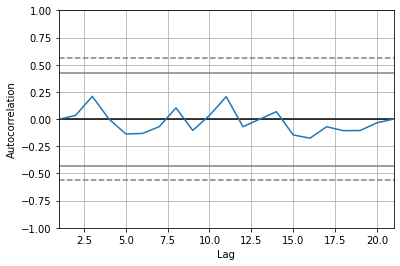

67797658023


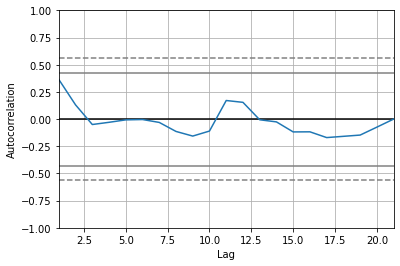

14480530534


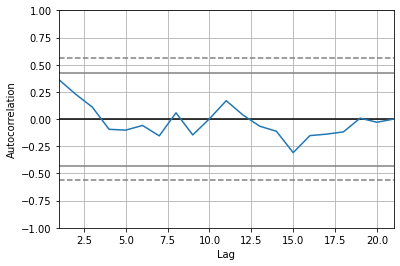

67979471799


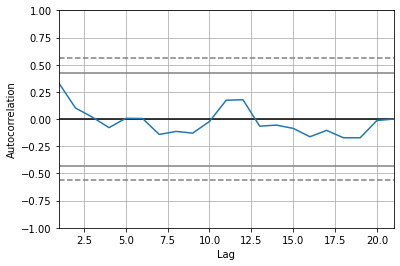

31686734877


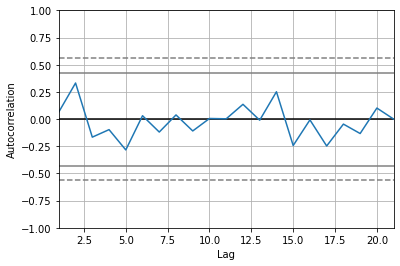

In [170]:
import random
random.seed(4302022)

for i in range(5):
    random_merchant = random.sample(merchant_abns.tolist(), 1)[0]
    
    print(random_merchant)
    
    filtereddf = df[df[random_merchant] == 1][['int_month', 'monthly_transactions']]
    filtereddf = filtereddf.sort_values('int_month')
    filtereddf = filtereddf['monthly_transactions']
    
    x = pd.plotting.autocorrelation_plot(filtereddf)
 
    x.plot()
 
    plt.show()


Use 2 lags.

In [171]:
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCol='merchant_abn', outputCol='merchant_abn_class')
indexer_fitted = indexer.fit(modeldf)
modeldf = indexer_fitted.transform(modeldf)
modeldf

merchant_abn,int_month,monthly_transactions,merchant_abn_class
38700038932,11,371,1327.0
35344855546,19,73,1181.0
78916025936,13,4,3108.0
60654402457,5,4,2279.0
37470904997,14,0,1270.0
61867784114,3,3,2323.0
46331355995,7,84,1668.0
35927874515,2,137,1214.0
57093429717,20,54,2145.0
14316652139,8,12,190.0


In [172]:
from pyspark.ml.feature import OneHotEncoder
encoder = OneHotEncoder(inputCols=['merchant_abn_class'], outputCols=['merchant_abn_ohe'])
modeldf = encoder.fit(modeldf).transform(modeldf)
modeldf

merchant_abn,int_month,monthly_transactions,merchant_abn_class,merchant_abn_ohe
38700038932,11,371,1327.0,"(4017,[1327],[1.0])"
35344855546,19,73,1181.0,"(4017,[1181],[1.0])"
78916025936,13,4,3108.0,"(4017,[3108],[1.0])"
60654402457,5,4,2279.0,"(4017,[2279],[1.0])"
37470904997,14,0,1270.0,"(4017,[1270],[1.0])"
61867784114,3,3,2323.0,"(4017,[2323],[1.0])"
46331355995,7,84,1668.0,"(4017,[1668],[1.0])"
35927874515,2,137,1214.0,"(4017,[1214],[1.0])"
57093429717,20,54,2145.0,"(4017,[2145],[1.0])"
14316652139,8,12,190.0,"(4017,[190],[1.0])"


In [173]:
from pyspark.sql.window import Window

partition = Window.partitionBy("merchant_abn").orderBy("int_month")
modeldf = modeldf.withColumn('monthly_transactions-1', lag('monthly_transactions', 1).over(partition))
modeldf = modeldf.withColumn('monthly_transactions-2', lag('monthly_transactions', 2).over(partition))
modeldf.show(60)

+------------+---------+--------------------+------------------+----------------+----------------------+----------------------+
|merchant_abn|int_month|monthly_transactions|merchant_abn_class|merchant_abn_ohe|monthly_transactions-1|monthly_transactions-2|
+------------+---------+--------------------+------------------+----------------+----------------------+----------------------+
| 10023283211|        1|                   3|               0.0|(4017,[0],[1.0])|                  null|                  null|
| 10023283211|        2|                 103|               0.0|(4017,[0],[1.0])|                     3|                  null|
| 10023283211|        3|                 117|               0.0|(4017,[0],[1.0])|                   103|                     3|
| 10023283211|        4|                 126|               0.0|(4017,[0],[1.0])|                   117|                   103|
| 10023283211|        5|                 129|               0.0|(4017,[0],[1.0])|                   126|

In [175]:
modeldf = modeldf.na.drop()
modeldf.count()

76342

In [180]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler

SPLIT_MONTH = 18

vecAssembler = VectorAssembler(inputCols=['merchant_abn_ohe', 'int_month', 
                                          'monthly_transactions-1', 
                                          'monthly_transactions-2'], 
                               outputCol='features')

train = modeldf.filter(col('int_month') <= SPLIT_MONTH)
test = modeldf.filter(col('int_month') > SPLIT_MONTH)

train = vecAssembler.transform(train)
test = vecAssembler.transform(test)
train

merchant_abn,int_month,monthly_transactions,merchant_abn_class,merchant_abn_ohe,monthly_transactions-1,monthly_transactions-2,features
10023283211,3,117,0.0,"(4017,[0],[1.0])",103,3,"(4020,[0,4017,401..."
10023283211,4,126,0.0,"(4017,[0],[1.0])",117,103,"(4020,[0,4017,401..."
10023283211,5,129,0.0,"(4017,[0],[1.0])",126,117,"(4020,[0,4017,401..."
10023283211,6,137,0.0,"(4017,[0],[1.0])",129,126,"(4020,[0,4017,401..."
10023283211,7,122,0.0,"(4017,[0],[1.0])",137,129,"(4020,[0,4017,401..."
10023283211,8,150,0.0,"(4017,[0],[1.0])",122,137,"(4020,[0,4017,401..."
10023283211,9,141,0.0,"(4017,[0],[1.0])",150,122,"(4020,[0,4017,401..."
10023283211,10,176,0.0,"(4017,[0],[1.0])",141,150,"(4020,[0,4017,401..."
10023283211,11,176,0.0,"(4017,[0],[1.0])",176,141,"(4020,[0,4017,401..."
10023283211,12,107,0.0,"(4017,[0],[1.0])",176,176,"(4020,[0,4017,401..."


In [182]:
lr = LinearRegression(featuresCol='features', labelCol='monthly_transactions')
lrModel = lr.fit(train)

22/10/04 20:18:55 WARN Instrumentation: [2d6ca55f] regParam is zero, which might cause numerical instability and overfitting.


22/10/04 20:18:56 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/10/04 20:18:56 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


22/10/04 20:18:57 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


In [183]:
predictions = lrModel.transform(test)
predictions

merchant_abn,int_month,monthly_transactions,merchant_abn_class,merchant_abn_ohe,monthly_transactions-1,monthly_transactions-2,features,prediction
10023283211,19,146,0.0,"(4017,[0],[1.0])",166,134,"(4020,[0,4017,401...",163.63956154699477
10023283211,20,173,0.0,"(4017,[0],[1.0])",146,166,"(4020,[0,4017,401...",151.06678475805126
10023283211,21,164,0.0,"(4017,[0],[1.0])",173,146,"(4020,[0,4017,401...",168.34671245059747
10142254217,19,149,1.0,"(4017,[1],[1.0])",149,125,"(4020,[1,4017,401...",148.30986648992936
10142254217,20,130,1.0,"(4017,[1],[1.0])",149,149,"(4020,[1,4017,401...",147.12922954354627
10142254217,21,185,1.0,"(4017,[1],[1.0])",130,149,"(4020,[1,4017,401...",138.0587451957229
10165489824,19,1,2.0,"(4017,[2],[1.0])",0,1,"(4020,[2,4017,401...",8.833525496002338
10165489824,20,1,2.0,"(4017,[2],[1.0])",1,0,"(4020,[2,4017,401...",10.505535479886703
10165489824,21,0,2.0,"(4017,[2],[1.0])",1,1,"(4020,[2,4017,401...",11.45944806916243
10187291046,19,15,3.0,"(4017,[3],[1.0])",13,13,"(4020,[3,4017,401...",22.77479081396434


34564250941


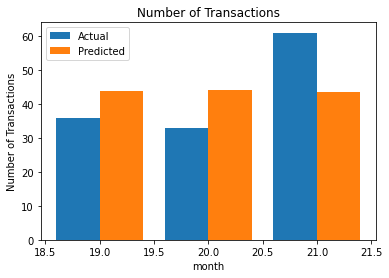

98065308169


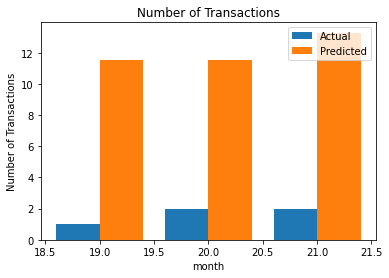

24043105437


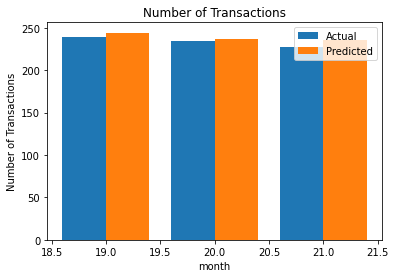

57900494384


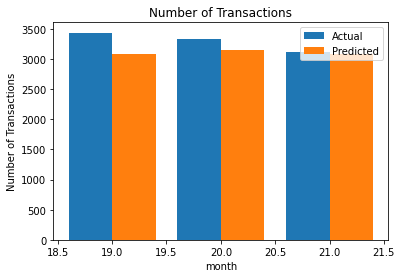

20435488659


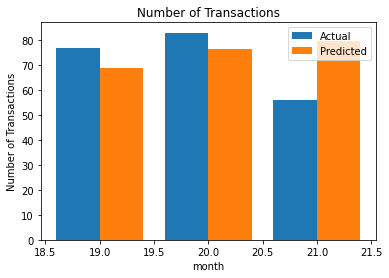

In [198]:
#random.seed(4302023)

dfp = predictions.toPandas()
X = [19, 20, 21]

for i in range(5):
    random_merchant = random.sample(merchant_abns.tolist(), 1)[0]
    print(random_merchant)
    X_axis = np.arange(19, 22)
    plt.bar(X_axis - 0.2, dfp[dfp['merchant_abn']==random_merchant]["monthly_transactions"], 0.4, label = 'Actual')
    plt.bar(X_axis + 0.2, dfp[dfp['merchant_abn']==random_merchant]["prediction"], 0.4, label = 'Predicted')
    plt.legend()
    plt.xlabel('month')
    plt.ylabel('Number of Transactions')
    plt.title('Number of Transactions')
    plt.show()